Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline

import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import urllib
import zipfile
from matplotlib import pylab
from sklearn.manifold import TSNE
import scipy.spatial as sp

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
    """Download a file if not present, and make sure it's the right size."""
    if not os.path.exists(filename):
        filename, _ = urllib.urlretrieve(url + filename, filename)
    statinfo = os.stat(filename)
    if statinfo.st_size == expected_bytes:
        print 'Found and verified', filename
    else:
        print statinfo.st_size
        raise Exception('Failed to verify ' + filename + '. Can you get to it with a browser?')
    return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
def read_data(filename):
    f = zipfile.ZipFile(filename)
    for name in f.namelist():
        return f.read(name).split()
    f.close()

words = read_data(filename)
print 'Data size', len(words)

Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
    count = [['UNK', -1]]
    count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
    dictionary = dict()
    for word, _ in count:
        dictionary[word] = len(dictionary)
    data = list()
    unk_count = 0
    for word in words:
        if word in dictionary:
            index = dictionary[word]
        else:
            index = 0  # dictionary['UNK']
            unk_count = unk_count + 1
        data.append(index)
    count[0][1] = unk_count
    reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
    return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print 'Most common words (+UNK)', count[:5]
print 'Sample data', data[:10]
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5239, 3084, 12, 6, 195, 2, 3137, 46, 59, 156]


Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size / num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            batch[i * num_skips + j] = buffer[skip_window]
            labels[i * num_skips + j, 0] = buffer[target]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

batch, labels = generate_batch(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print batch[i], '->', labels[i, 0]
    print reverse_dictionary[batch[i]], '->', reverse_dictionary[labels[i, 0]]

3084 -> 5239
originated -> anarchism
3084 -> 12
originated -> as
12 -> 6
as -> a
12 -> 3084
as -> originated
6 -> 195
a -> term
6 -> 12
a -> as
195 -> 2
term -> of
195 -> 6
term -> a


Train a skip-gram model.

In [6]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 8 # Random set of words to evaluate similarity on.
valid_window = 500 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(xrange(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [7]:
from datetime import datetime

In [8]:
t1 = datetime.utcnow()
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print "Initialized"
    average_loss = 0
    for step in xrange(num_steps):
        batch_data, batch_labels = generate_batch(
            batch_size, num_skips, skip_window)
        
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print "Average loss at step", step, ":", average_loss
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = "%s %s," % (log, close_word)
                print log
    final_embeddings = normalized_embeddings.eval()
t2 = datetime.utcnow()

Initialized
Average loss at step 0 : 8.61209106445
Nearest to england: xenosaga, screws, screwball, sacs, mico, classical, fibre, beaufort,
Nearest to produced: scottish, uta, house, timber, moose, dm, whitewater, haakon,
Nearest to written: distorted, emphasising, courted, falconiformes, rime, devoid, laser, scandinavians,
Nearest to j: skynyrd, happiest, opera, nirvana, noonan, dianetic, lizzy, khazars,
Nearest to he: tov, azo, ragged, rovere, mmol, dodger, savage, anthem,
Nearest to army: embedding, gwen, effort, devoured, demography, unfashionable, humanism, harrisburg,
Nearest to even: tyrol, section, appear, reflexive, widget, impeded, ladies, compton,
Nearest to father: obscurity, vespers, hipper, plundered, elevating, heldenplatz, rightful, sci,
Average loss at step 2000 : 4.35714482319
Average loss at step 4000 : 3.86260799983
Average loss at step 6000 : 3.78861580718
Average loss at step 8000 : 3.68325000766
Average loss at step 10000 : 3.61266820312
Nearest to england: xenos

In [9]:
print t2 - t1

0:06:18.148461


In [10]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

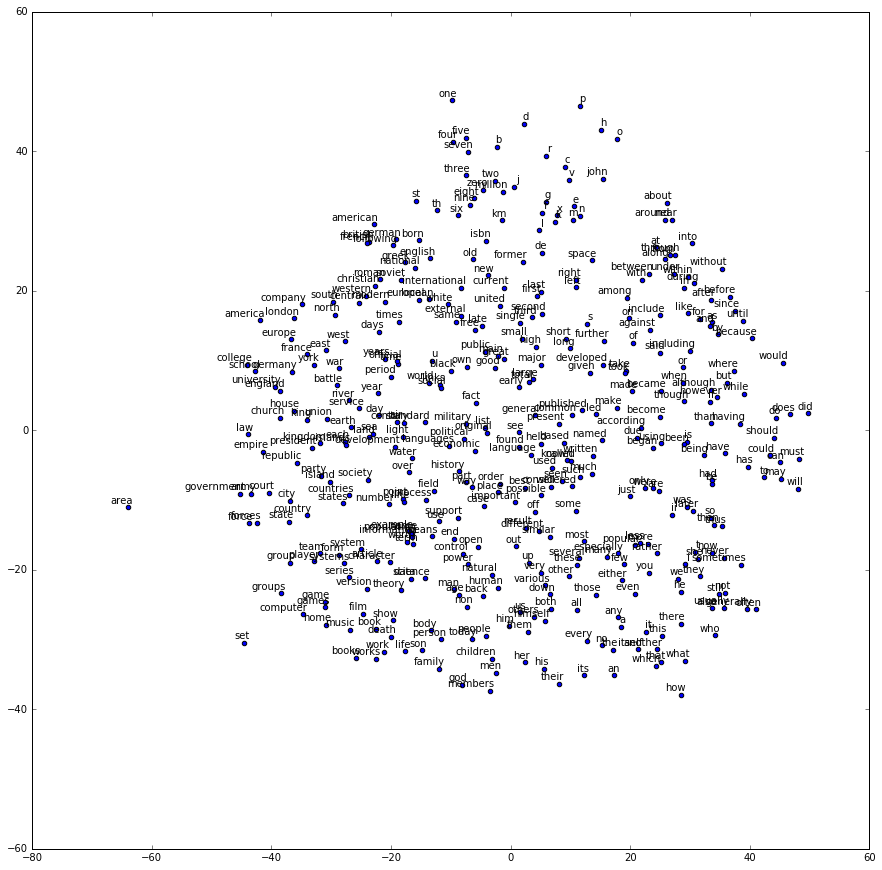

In [11]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in xrange(1, num_points+1)]
plot(two_d_embeddings, words)

In [12]:
skipgram_embeddings = final_embeddings

In [13]:
from sklearn.metrics.pairwise import cosine_similarity

In [14]:
term = 'king'
for i in sp.distance.cdist([skipgram_embeddings[dictionary[term]]], skipgram_embeddings, 'cosine').argsort()[0][1:8]:
    print reverse_dictionary[i]

vardar
wolfenstein
smith
demiurge
telling
church
gundestrup


---

Problem
-------

An alternative to Word2Vec is called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

In [15]:
data_index = 0

def generate_batch_cbow(batch_size, num_skips, skip_window):
    global data_index
    assert batch_size % num_skips == 0
    assert num_skips <= 2 * skip_window
    batch = np.ndarray(shape=(batch_size), dtype=np.int32)
    labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
    span = 2 * skip_window + 1 # [ skip_window target skip_window ]
    buffer = collections.deque(maxlen=span)
    for _ in range(span):
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    for i in range(batch_size / num_skips):
        target = skip_window  # target label at the center of the buffer
        targets_to_avoid = [ skip_window ]
        for j in range(num_skips):
            while target in targets_to_avoid:
                target = random.randint(0, span - 1)
            targets_to_avoid.append(target)
            #batch[i * num_skips + j] = buffer[skip_window]
            batch[i * num_skips + j] = buffer[target]
            #labels[i * num_skips + j, 0] = buffer[target]
            labels[i * num_skips + j, 0] = buffer[skip_window]
        buffer.append(data[data_index])
        data_index = (data_index + 1) % len(data)
    return batch, labels

batch, labels = generate_batch_cbow(batch_size=8, num_skips=2, skip_window=1)
for i in range(8):
    print batch[i], '->', labels[i, 0]
    print reverse_dictionary[batch[i]], '->', reverse_dictionary[labels[i, 0]]

5239 -> 3084
anarchism -> originated
12 -> 3084
as -> originated
3084 -> 12
originated -> as
6 -> 12
a -> as
12 -> 6
as -> a
195 -> 6
term -> a
2 -> 195
of -> term
6 -> 195
a -> term


In [16]:
valid_examples

array([316, 459, 297, 317,  36, 337, 139, 409])

In [17]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 8 # Random set of words to evaluate similarity on.
valid_window = 500 # Only pick dev samples in the head of the distribution.
#valid_examples = np.array(random.sample(xrange(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default():
    # Input data.
    train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
    train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
    valid_dataset = tf.constant(valid_examples, dtype=tf.int32)

    # Variables.
    embeddings = tf.Variable(
        tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
    softmax_weights = tf.Variable(
        tf.truncated_normal([vocabulary_size, embedding_size], stddev=1.0 / math.sqrt(embedding_size)))
    softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))

    # Model.
    # Look up embeddings for inputs.
    embed = tf.nn.embedding_lookup(embeddings, train_dataset)
    # Compute the softmax loss, using a sample of the negative labels each time.
    loss = tf.reduce_mean(tf.nn.sampled_softmax_loss(softmax_weights, softmax_biases, embed,
                               train_labels, num_sampled, vocabulary_size))

    # Optimizer.
    optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)

    # Compute the similarity between minibatch examples and all embeddings.
    # We use the cosine distance:
    norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
    normalized_embeddings = embeddings / norm
    valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
    similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [18]:
t1 = datetime.utcnow()
num_steps = 100001

with tf.Session(graph=graph) as session:
    tf.initialize_all_variables().run()
    print "Initialized"
    average_loss = 0
    for step in xrange(num_steps):
        batch_data, batch_labels = generate_batch_cbow(
            batch_size, num_skips, skip_window)
        feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
        _, l = session.run([optimizer, loss], feed_dict=feed_dict)
        average_loss += l
        if step % 2000 == 0:
            if step > 0:
                average_loss = average_loss / 2000
            # The average loss is an estimate of the loss over the last 2000 batches.
            print "Average loss at step", step, ":", average_loss
            average_loss = 0
        # note that this is expensive (~20% slowdown if computed every 500 steps)
        if step % 10000 == 0:
            sim = similarity.eval()
            for i in xrange(valid_size):
                valid_word = reverse_dictionary[valid_examples[i]]
                top_k = 8 # number of nearest neighbors
                nearest = (-sim[i, :]).argsort()[1:top_k+1]
                log = "Nearest to %s:" % valid_word
                for k in xrange(top_k):
                    close_word = reverse_dictionary[nearest[k]]
                    log = "%s %s," % (log, close_word)
                print log
    final_embeddings = normalized_embeddings.eval()
t2 = datetime.utcnow()

Initialized
Average loss at step 0 : 8.05254936218
Nearest to england: stub, shiloh, medicines, deacons, lockout, friendship, frankenstein, garlic,
Nearest to produced: amoeboids, branded, uffizi, atomism, brahe, navigators, mach, afrobeat,
Nearest to written: plaza, lauded, tonality, lawsuits, bipolar, downside, katakana, hawthorne,
Nearest to j: sdtv, exponents, authoring, ibelin, concessions, curves, timeframe, fredrick,
Nearest to he: boosts, toolbar, considerably, osman, rocky, parody, awa, globalization,
Nearest to army: million, side, elamites, elicit, hardwood, ombudsman, outkast, insecurity,
Nearest to even: mourner, supplanted, molasses, universite, saltpeter, foals, photographs, alliaceae,
Nearest to father: volumes, monika, huge, dusk, nobi, prick, vast, massively,
Average loss at step 2000 : 4.36258734953
Average loss at step 4000 : 3.86262834957
Average loss at step 6000 : 3.79297547817
Average loss at step 8000 : 3.68561241639
Average loss at step 10000 : 3.61784084445
N

In [19]:
print t2 - t1

0:06:21.386607


In [20]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000)
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

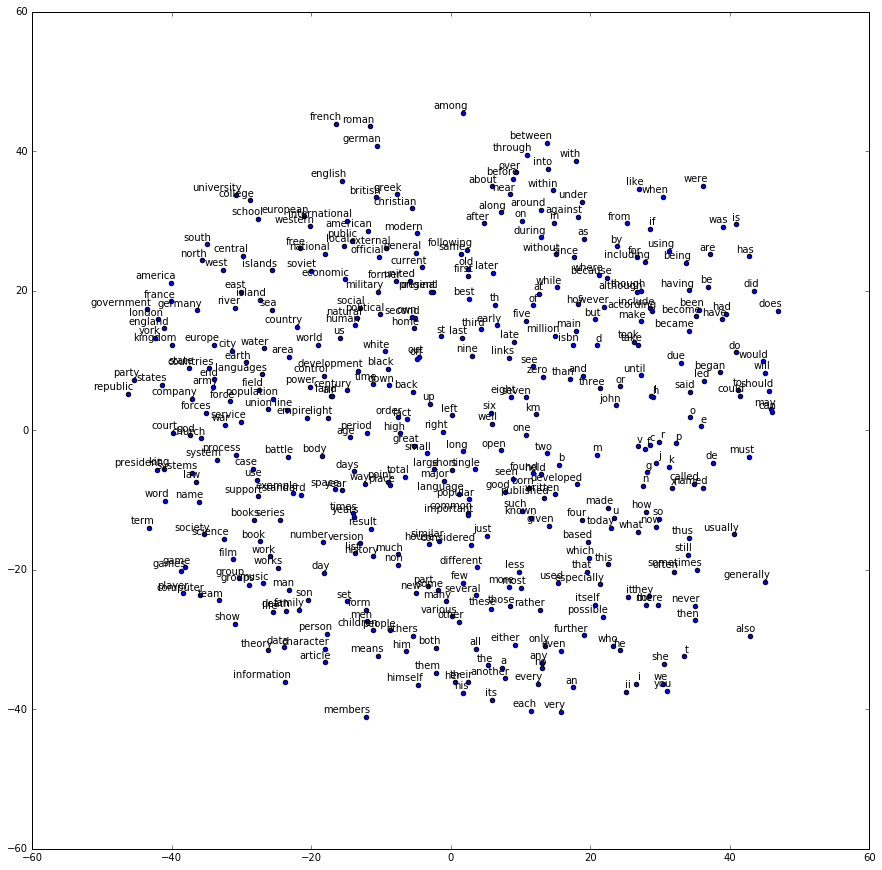

In [21]:
def plot(embeddings, labels):
    assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
    pylab.figure(figsize=(15,15))  # in inches
    for i, label in enumerate(labels):
        x, y = embeddings[i,:]
        pylab.scatter(x, y)
        pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                       ha='right', va='bottom')
    pylab.show()

words = [reverse_dictionary[i] for i in xrange(1, num_points+1)]
plot(two_d_embeddings, words)

In [22]:
cbow_embeddings = final_embeddings

In [81]:
count[150:200]

[('g', 8773),
 ('french', 8736),
 ('before', 8700),
 ('general', 8659),
 ('what', 8581),
 ('t', 8491),
 ('against', 8432),
 ('n', 8372),
 ('high', 8337),
 ('links', 8312),
 ('could', 8304),
 ('based', 8244),
 ('those', 8209),
 ('now', 8206),
 ('second', 8110),
 ('de', 8002),
 ('music', 7987),
 ('another', 7933),
 ('large', 7898),
 ('she', 7896),
 ('f', 7878),
 ('external', 7862),
 ('german', 7858),
 ('different', 7797),
 ('modern', 7790),
 ('great', 7770),
 ('do', 7763),
 ('common', 7698),
 ('set', 7682),
 ('list', 7672),
 ('south', 7628),
 ('series', 7611),
 ('major', 7585),
 ('game', 7553),
 ('power', 7522),
 ('long', 7488),
 ('country', 7481),
 ('king', 7456),
 ('law', 7435),
 ('group', 7417),
 ('film', 7400),
 ('still', 7378),
 ('until', 7368),
 ('north', 7328),
 ('international', 7262),
 ('term', 7219),
 ('we', 7118),
 ('end', 7113),
 ('book', 7110),
 ('found', 7043)]

In [112]:
term = 'government'

In [113]:
for i in sp.distance.cdist([skipgram_embeddings[dictionary[term]]], skipgram_embeddings, 'cosine').argsort()[0][1:8]:
    print reverse_dictionary[i]

starving
council
congress
economy
federal
colfax
state


In [114]:
for i in sp.distance.cdist([cbow_embeddings[dictionary[term]]], cbow_embeddings, 'cosine').argsort()[0][1:8]:
    print reverse_dictionary[i]

army
administration
governments
president
council
troops
delays
